In [ ]:
import os, json, random, pathlib, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm.notebook as tqdm

In [ ]:
#ユーザー設定
DATA_DIR = "dataset"
OUTPUT_DIR = "output"
IMG_SIZE = (160,160)
BATCH_SIZE = 4
EPOCHS = 10
VAL_SPLIT = 0.2
SEED = 42
POS_LABEL = "boil"
THRESHOLD = 0.5

In [ ]:
!unzip /content/boil.zip -d /content/dataset
!unzip /content/unboil.zip -d /content/dataset

Archive:  /content/boil.zip
   creating: /content/dataset/boil/
  inflating: /content/dataset/boil/video_0851.jpg  
  inflating: /content/dataset/boil/video_0852.jpg  
  inflating: /content/dataset/boil/video_0853.jpg  
  inflating: /content/dataset/boil/video_0854.jpg  
  inflating: /content/dataset/boil/video_0855.jpg  
  inflating: /content/dataset/boil/video_0856.jpg  
  inflating: /content/dataset/boil/video_0857.jpg  
  inflating: /content/dataset/boil/video_0858.jpg  
  inflating: /content/dataset/boil/video_0859.jpg  
  inflating: /content/dataset/boil/video_0860.jpg  
  inflating: /content/dataset/boil/video_0861.jpg  
  inflating: /content/dataset/boil/video_0862.jpg  
  inflating: /content/dataset/boil/video_0863.jpg  
  inflating: /content/dataset/boil/video_0864.jpg  
  inflating: /content/dataset/boil/video_0865.jpg  
  inflating: /content/dataset/boil/video_0866.jpg  
  inflating: /content/dataset/boil/video_0867.jpg  
  inflating: /content/dataset/boil/video_0868.jpg  


In [ ]:
import tensorflow as tf
def crop_left_top(img):
    return tf.image.crop_to_bounding_box(img, 5, 5, 160, 160)

def prepare(ds, training=False):
  norm = tf.keras.layers.Rescaling(1./255)
  aug = tf.keras.Sequential([
    tf.keras.layers.Lambda(crop_left_top),
  ])
  AUTOTUNE = tf.data.AUTOTUNE

  ds = ds.map(lambda x,y: (norm(x),y), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda x,y: (aug(x),y), num_parallel_calls=AUTOTUNE)
  ds = ds.shuffle(1000)
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# シードを設定する
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#  データセット作成
os.makedirs(OUTPUT_DIR, exist_ok=True)
data_dir = pathlib.Path(DATA_DIR)
assert (data_dir / "boil").exists() and (data_dir / "unboil").exists(), "dataset/boilとdataset/unboilを用意してください"
class_names = ["boil", "unboil"]
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=class_names
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=class_names
)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)

Found 1311 files belonging to 2 classes.
Using 1049 files for training.
Found 1311 files belonging to 2 classes.
Using 262 files for validation.


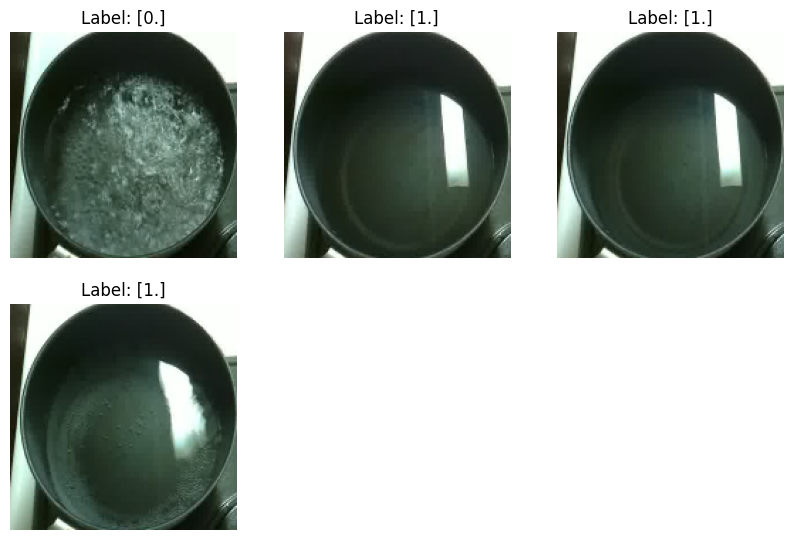

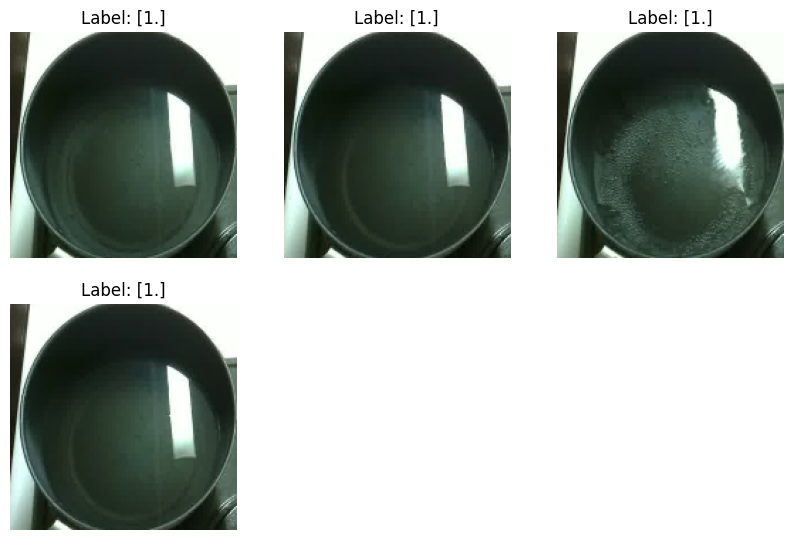

In [ ]:
import matplotlib.pyplot as plt

# train_ds は prepare() を通した後の Dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):  # 9枚まで表示
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break

for images, labels in val_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):  # 9枚まで表示
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break

In [ ]:
def build_small_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = build_small_cnn(IMG_SIZE + (3,))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(threshold=THRESHOLD, name="acc@thr"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [ ]:
from tqdm.keras import TqdmCallback
#訓練を行って保存する
cb = [
    TqdmCallback(
        verbose=0
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, "boil_best.keras"),
        monitor="val_auc", mode="max", save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=3, restore_best_weights=True
    )
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
# json形式で保存
with open(os.path.join(OUTPUT_DIR, "history.json"), "w") as f:
    json.dump(history.history, f)

# 保存（Keras形式）
model.save(os.path.join(OUTPUT_DIR, "boil_final.keras"))

0epoch [00:00, ?epoch/s]

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - acc@thr: 0.6076 - auc: 0.4813 - loss: 0.6623 - precision: 0.6068 - recall: 0.9997 - val_acc@thr: 0.9771 - val_auc: 0.9984 - val_loss: 0.1881 - val_precision: 0.9778 - val_recall: 0.9888
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc@thr: 0.9043 - auc: 0.9637 - loss: 0.2435 - precision: 0.9074 - recall: 0.9408 - val_acc@thr: 0.9733 - val_auc: 0.9993 - val_loss: 0.0603 - val_precision: 1.0000 - val_recall: 0.9607
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc@thr: 0.9633 - auc: 0.9876 - loss: 0.1079 - precision: 0.9656 - recall: 0.9742 - val_acc@thr: 0.9809 - val_auc: 0.9997 - val_loss: 0.0413 - val_precision: 0.9779 - val_recall: 0.9944
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc@thr: 0.9704 - auc: 0.9895 - loss: 0.0900 - precision: 0.9760 - recall: 0.9749 - val_acc@thr: 0.9924 - val_auc: 0.9997 - val_loss: 0.0373 - val_precision: 1.0000 - val_recall: 0.9888
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# モデルの保存後...
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 最適化フラグ（サイズ縮小・高速化）
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# （オプション）FP16量子化：精度を保ちつつ軽量化
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# 保存
with open('model_quant.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpwz3ftqd6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_51')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133494583589968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494564280592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031920656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031918352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031921040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031918160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031920272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031921616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031920464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133494031921232: TensorSpec(shape=(), dtype=tf.resource, name=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


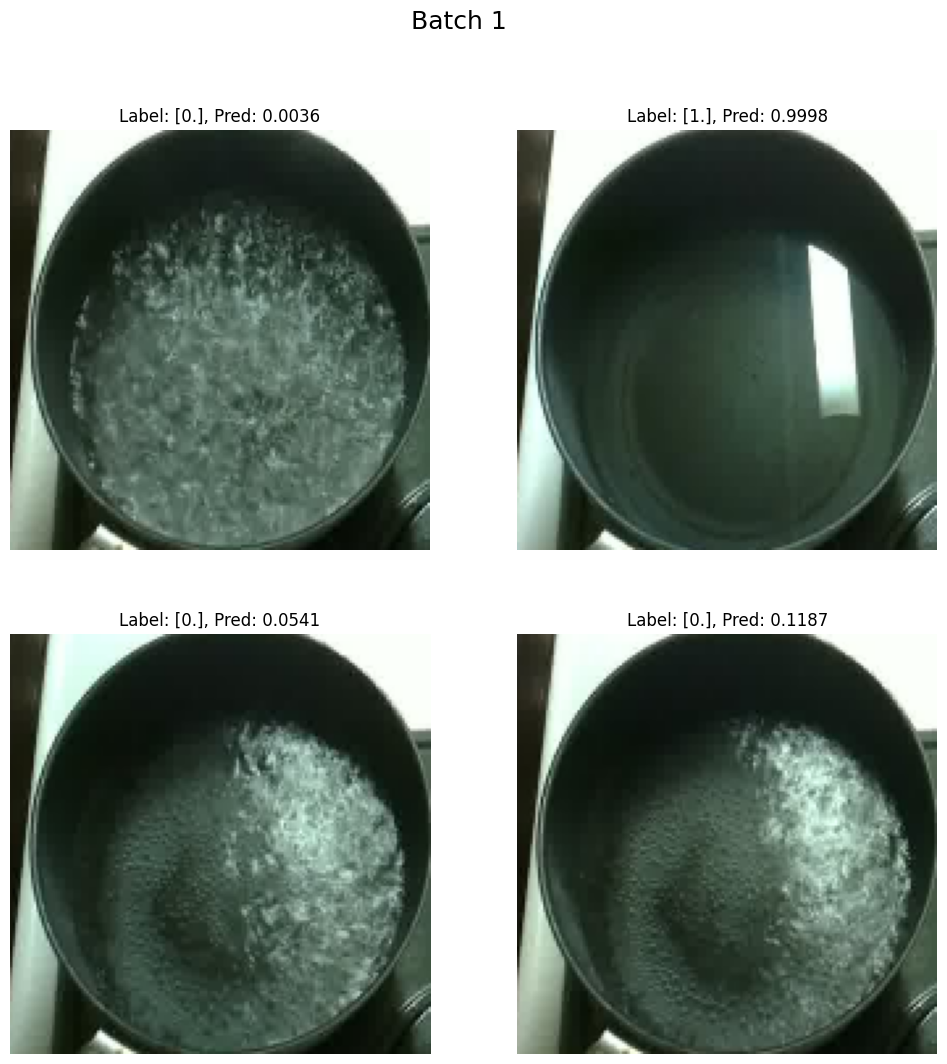

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


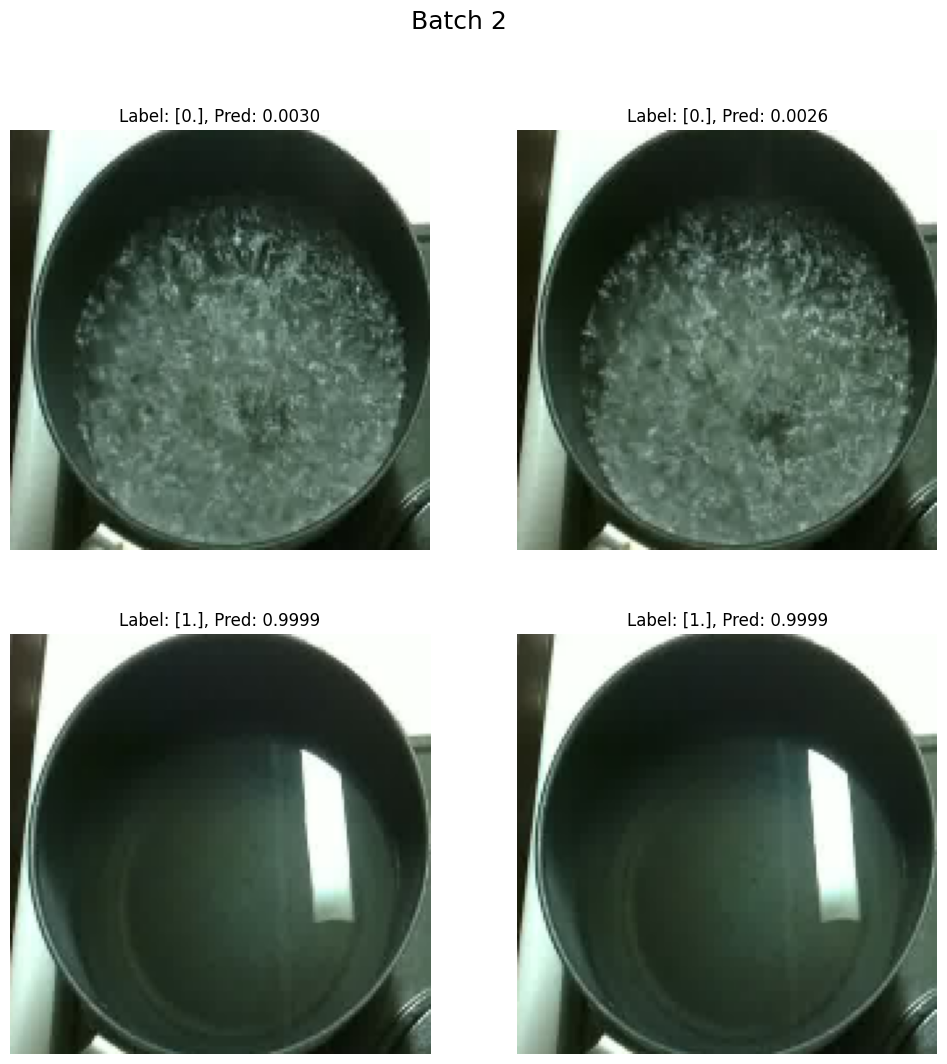

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


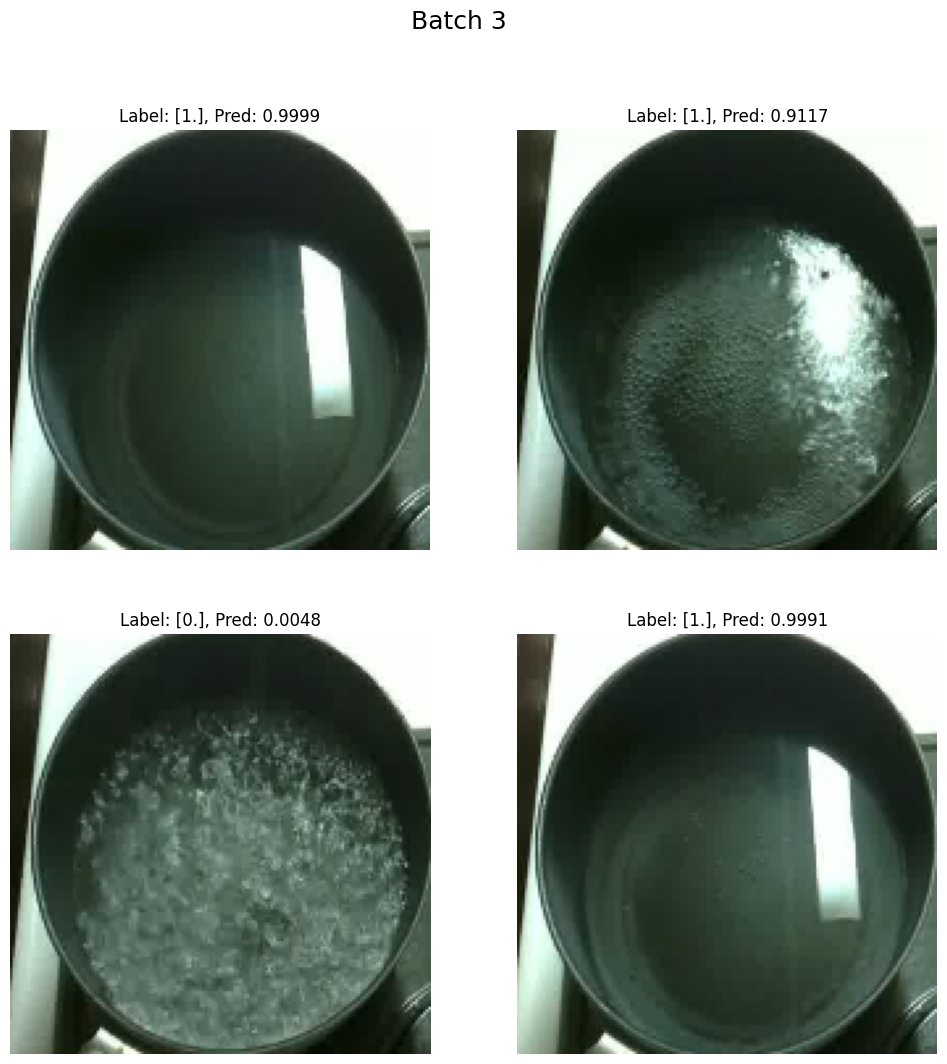

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


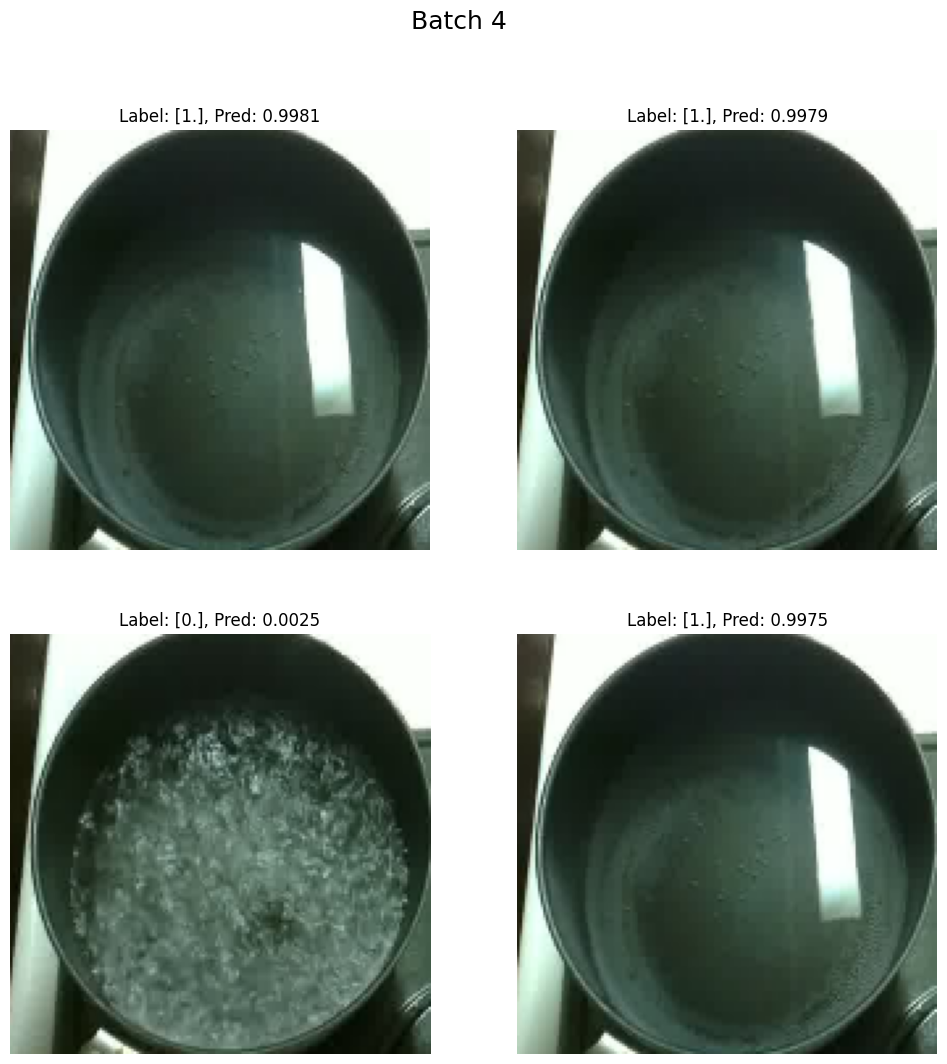

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


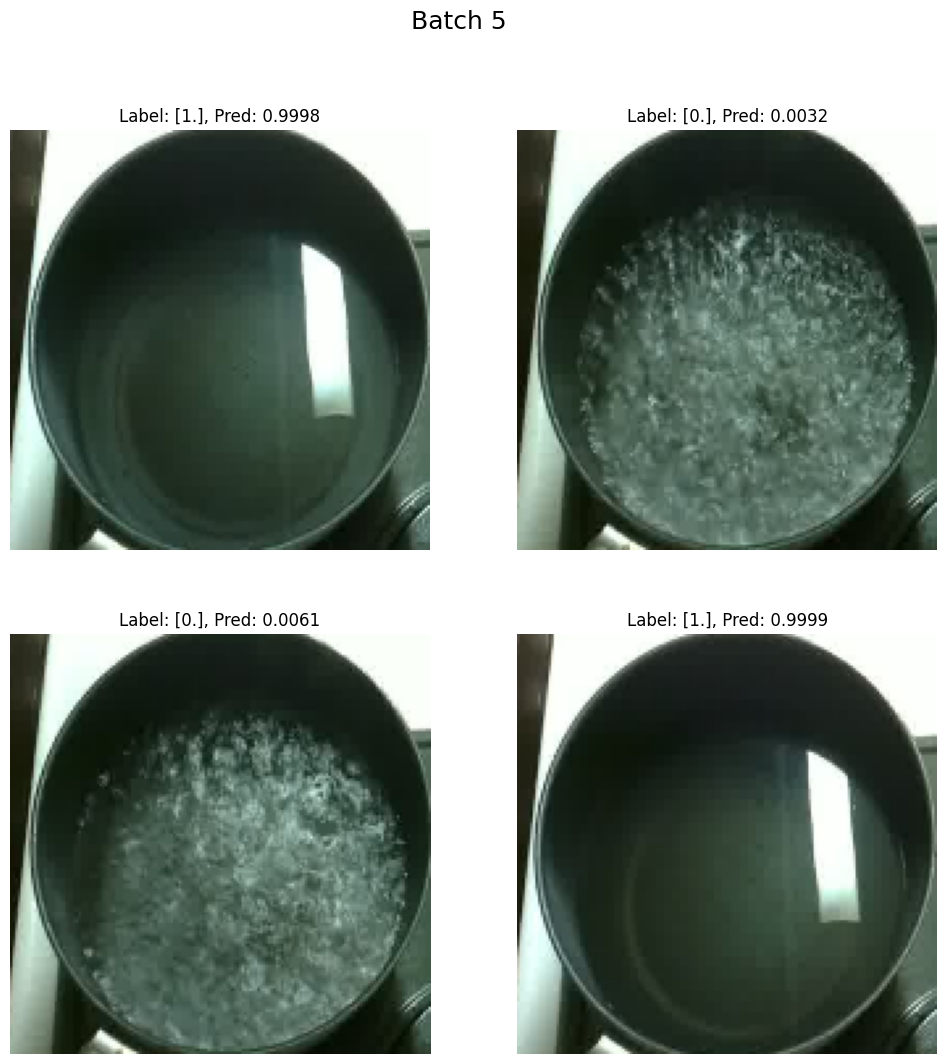

In [ ]:
num_batches = 5  # 取りたいバッチ数

for batch_idx, (images, labels) in enumerate(val_ds.take(num_batches)):
    preds = model.predict(images).reshape(-1)

    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Batch {batch_idx+1}", fontsize=18)

    # とりあえず各バッチの最初の4枚だけ表示
    for i in range(min(4, images.shape[0])): # Change 10 to 4 to match the subplot grid
        ax = plt.subplot(2, 2, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}, Pred: {preds[i]:.4f}")
        plt.axis("off")

    plt.show()

In [ ]:
#学習の経過を確認する
with open(os.path.join(OUTPUT_DIR,"history.json"), 'r') as f:
  history = json.load(f)

epochs = range(len(history["loss"]))

def plot_history(history,metric_name):
  train_metric = history[metric_name]
  val_metric = history["val_" + metric_name]
  plt.figure(figsize=(10,6))
  plt.plot(epochs, train_metric, 'b', label="Training " + metric_name)
  plt.plot(epochs, val_metric, 'r', label="Validation " + metric_name)
  plt.title(f'Training and Validation {metric_name} Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel(metric_name.capitalize())
  plt.legend()
  plt.show()

plot_history(history, 'loss')
plot_history(history, 'acc@thr')
plot_history(history, 'auc')
plot_history(history, 'precision')
plot_history(history, 'recall')